http://dati.istat.it/Index.aspx?QueryId=33703#

https://www.arpa.veneto.it/dati-ambientali/dati-storici/meteo-idro-nivo/ultimi_anni --> NUMERO 227

In [ ]:
# load and manipulation
import pandas as pd
import json
# plots
import matplotlib.pyplot as plt
import seaborn as sns
# modeling
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


## Load True Data

In [ ]:
# Prezzi dei prodotti agricoli

def create_ppa(file_path, prod):
  ppa = pd.read_csv(file_path, sep=",")
  # 'ortive' 'concimi e ammendanti' 'insetticidi', base=2015
  ppa = ppa[(ppa["Prodotti acquistati"]==prod) &
            (ppa["Tipo indice"]=='indice dei prezzi dei prodotti acquistati dagli agricoltori (base 2015=100) - dati mensili')]

  ppa.drop(columns=["ITTER107", "Territorio", "TIPO_DATO2", "Tipo indice", "PRODCONS_AGRI_A", "Prodotti acquistati",
                    "Seleziona periodo", "Flag Codes", "Flags"],
          inplace=True)

  ppa["TIME"] = pd.to_datetime(ppa["TIME"])
  ppa["TIME"] = ppa["TIME"].dt.to_period('M')
  prod = prod.split(" ")[0]
  ppa.rename(columns={"Value": "PPA_"+str(prod), "TIME":"Anno_Mese"}, inplace=True)
  return ppa

ppa_ortive = create_ppa("/content/DCSP_PREZZIAGR_02012025184621931.csv", "ortive")
ppa_concimi = create_ppa("/content/DCSP_PREZZIAGR_02012025184621931.csv", "concimi e ammendanti")
ppa_insetticidi = create_ppa("/content/DCSP_PREZZIAGR_02012025184621931.csv", "insetticidi")

ppa = pd.merge(ppa_ortive, ppa_concimi, on='Anno_Mese', how='inner')
ppa = pd.merge(ppa, ppa_insetticidi, on='Anno_Mese', how='inner')
ppa.head()
# 2020-01 to 2023-09

,Anno_Mese,PPA_ortive,PPA_concimi,PPA_insetticidi
0,2020-01,106.6,93.3,114.8
1,2020-02,106.7,93.4,114.4
2,2020-03,107.8,93.5,115.0
3,2020-04,106.0,93.2,115.2
4,2020-05,106.8,92.9,115.2


In [ ]:
## Radiazioni Solari

### 2023
def create_rad_sol(file_path):
  with open(file_path, 'r') as f:
      data = json.load(f)
  rad_sol = pd.json_normalize(data['data'])
  rad_sol.rename(columns={'valore': 'rad'}, inplace=True)
  rad_sol["rad"] = rad_sol["rad"].astype(float)

  rad_sol.drop(columns=["codice_stazione", "nome_stazione", "nome_sensore", "unitnm", "tipo", "aggiornamento"], inplace=True)

  rad_sol['dataora'] = pd.to_datetime(rad_sol['dataora'])
  rad_sol['Anno_Mese'] = rad_sol['dataora'].dt.to_period('M')

  monthly_rad_sol = rad_sol.groupby('Anno_Mese')['rad'].mean().reset_index()
  return monthly_rad_sol

monthly_rad_sol2021 = create_rad_sol("/content/sol2021.json")
monthly_rad_sol2022 = create_rad_sol("/content/sol2022.json")
monthly_rad_sol2023 = create_rad_sol("/content/sol2023.json")

### Concatenate

monthly_rad_sol = pd.concat([monthly_rad_sol2021, monthly_rad_sol2022, monthly_rad_sol2023])
monthly_rad_sol.head()

,Anno_Mese,rad
0,2021-01,4.386645
1,2021-02,7.989321
2,2021-03,15.490258
3,2021-04,17.881933
4,2021-05,21.416387


In [ ]:
## Precipitazioni

def create_prec(file_path):
  with open(file_path, 'r') as f:
    data = json.load(f)

  prec = pd.json_normalize(data['data'])
  prec.rename(columns={'valore': 'prec'}, inplace=True)
  prec["prec"] = prec["prec"].astype(float)

  prec.drop(columns=["codice_stazione", "nome_stazione", "nome_sensore", "unitnm", "tipo", "aggiornamento"], inplace = True)

  prec['dataora'] = pd.to_datetime(prec['dataora'])
  prec['Anno_Mese'] = prec['dataora'].dt.to_period('M')
  monthly_prec = prec.groupby('Anno_Mese')['prec'].mean().reset_index()

  return monthly_prec

monthly_prec2021 = create_prec("/content/prec2021.json")
monthly_prec2022 = create_prec("/content/prec2022.json")
monthly_prec2023 = create_prec("/content/prec2023.json")

monthly_prec = pd.concat([monthly_prec2021, monthly_prec2022, monthly_prec2023])
monthly_prec.head()

,Anno_Mese,prec
0,2021-01,2.825806
1,2021-02,1.100000
2,2021-03,0.212903
3,2021-04,3.806667
4,2021-05,4.580645


In [ ]:
## Temperatura

def create_temp(file_path):
  with open(file_path, 'r') as f:
      data = json.load(f)

  temp = pd.json_normalize(data['data'])

  temp['valore'] = temp['valore'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
  temp['temp_min'] = temp['valore'].apply(lambda x: x['MINIMO'] if isinstance(x, dict) else None).astype(float)
  temp['temp_mean'] = temp['valore'].apply(lambda x: x['MEDIO'] if isinstance(x, dict) else None).astype(float)
  temp['temp_max'] = temp['valore'].apply(lambda x: x['MASSIMO'] if isinstance(x, dict) else None).astype(float)

  temp.drop(columns=["codice_stazione", "nome_stazione", "nome_sensore", "valore", "unitnm", "tipo", "aggiornamento"], inplace = True)

  temp['dataora'] = pd.to_datetime(temp['dataora'])
  temp['Anno_Mese'] = temp['dataora'].dt.to_period('M')
  monthly_temp = temp.groupby('Anno_Mese')[['temp_min', 'temp_mean', 'temp_max']].mean().reset_index()
  return monthly_temp

monthly_temp2021 = create_temp("/content/temp2021.json")
monthly_temp2022 = create_temp("/content/temp2022.json")
monthly_temp2023 = create_temp("/content/temp2023.json")

monthly_temp  = pd.concat([monthly_temp2021, monthly_temp2022, monthly_temp2023])
monthly_temp.head()

,Anno_Mese,temp_min,temp_mean,temp_max
0,2021-01,-0.754839,3.000000,7.341935
1,2021-02,3.000000,7.046429,11.914286
2,2021-03,1.880645,8.070968,14.722581
3,2021-04,6.170000,11.463333,16.483333
4,2021-05,10.951613,15.774194,21.006452


In [ ]:
## Merge dfs
merged_df = pd.merge(monthly_prec, monthly_rad_sol, on='Anno_Mese', how='inner')
merged_df = pd.merge(merged_df, monthly_temp, on='Anno_Mese', how='inner')
merged_df = pd.merge(merged_df, ppa, on='Anno_Mese', how='inner')
merged_df['Anno_Mese'] = merged_df['Anno_Mese'].dt.to_timestamp()
merged_df.head()

,Anno_Mese,prec,rad,temp_min,temp_mean,temp_max,PPA_ortive,PPA_concimi,PPA_insetticidi
0,2021-01-01,2.825806,4.386645,-0.754839,3.000000,7.341935,111.7,93.4,115.2
1,2021-02-01,1.100000,7.989321,3.000000,7.046429,11.914286,112.2,96.8,114.9
2,2021-03-01,0.212903,15.490258,1.880645,8.070968,14.722581,111.4,98.6,114.4
3,2021-04-01,3.806667,17.881933,6.170000,11.463333,16.483333,111.3,100.5,114.5
4,2021-05-01,4.580645,21.416387,10.951613,15.774194,21.006452,110.6,101.2,114.7


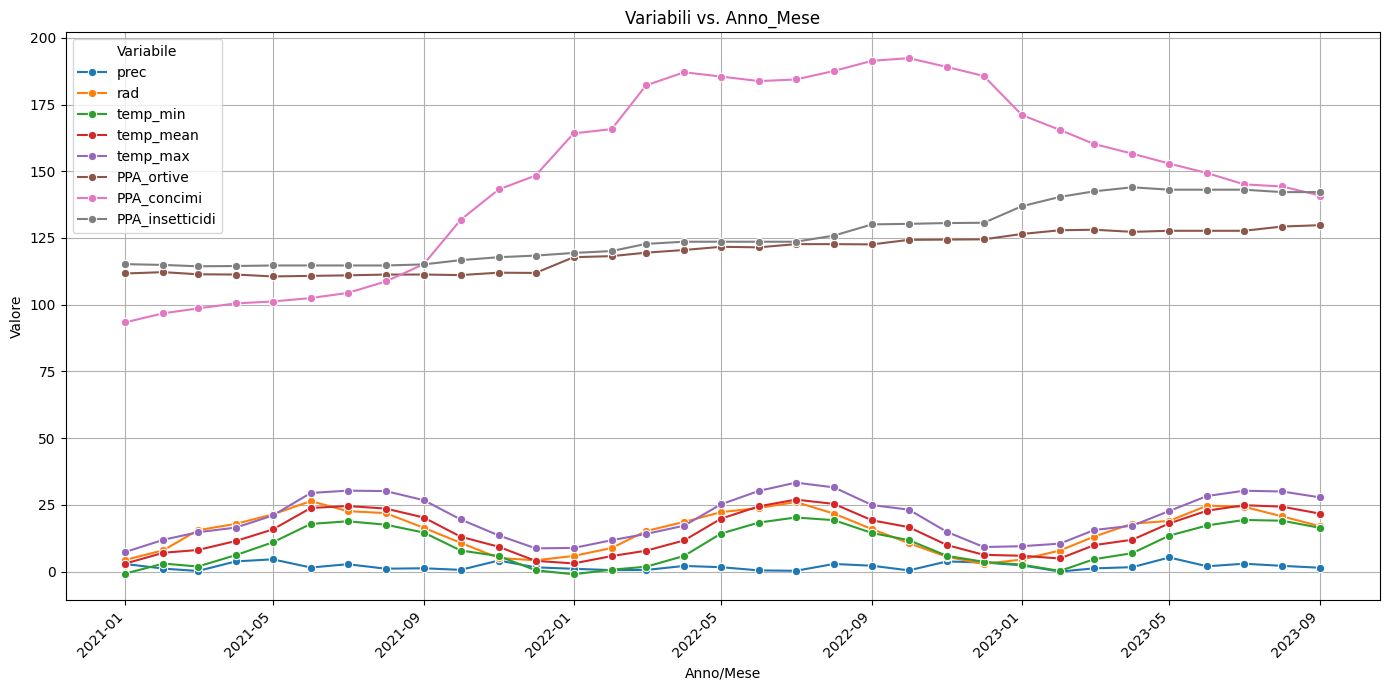

In [ ]:
# Trasformare il dataframe in formato lungo (long format)
merged_df_long = merged_df.melt(id_vars=['Anno_Mese'], var_name='Variable', value_name='Value')

# Creare il grafico
plt.figure(figsize=(14, 7))  # Dimensione del grafico
sns.lineplot(data=merged_df_long, x='Anno_Mese', y='Value', hue='Variable', marker='o')

# Aggiungere titolo e etichette
plt.title('Variabili vs. Anno_Mese')
plt.xlabel('Anno/Mese')
plt.ylabel('Valore')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.legend(title='Variabile')
plt.grid(True)
plt.tight_layout()
plt.show()


## Create Fake Data

### Useful Functions

In [ ]:
def plot_all_ts(merged_df, ortaggi):
  plt.figure(figsize=(12, 7))

  colors = ['green', 'orange', 'red', 'blue', 'purple', 'brown']

    # Ciclo per ogni ortaggio
  for i, ortaggio in enumerate(ortaggi):
    plt.plot(merged_df['Anno_Mese'], merged_df[ortaggio], label=ortaggio, marker='o', color=colors[i % len(colors)])

  str_title = 'Vendite Stagionali di ' + ', '.join(ortaggi)
  plt.title(str_title)
  plt.xlabel('Anno/Mese')
  plt.ylabel('Vendite')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Visualizza il grafico
  plt.show()

def plot_ts_ort(merged_df, ortaggio):

  plt.figure(figsize=(12, 7))
  plt.plot(merged_df['Anno_Mese'], merged_df[ortaggio], label=ortaggio, marker='o', color='green')

  plt.title('Vendite con Stagionalità Moderata e Rumore Aggiuntivo')
  plt.xlabel('Anno/Mese')
  plt.ylabel('Vendite')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def create_ortaggio(merged_df,
                    seasonal_factor,
                    trend_factors,
                    base_sales,
                    event_factors,
                    noise_factor=0.05,
                    event_factor=None):

  seasonal_component = seasonal_factor * np.sin(2 * np.pi * (merged_df['Anno_Mese'].dt.month - 11) / 12)

  trend_component = (
      trend_factors['prec'] * merged_df['prec'] * 0.1 +
      trend_factors['rad'] * merged_df['rad'] * 0.05 +
      trend_factors['temp_mean'] * merged_df['temp_mean'] * 0.1 +
      trend_factors['PPA_ortive'] * merged_df['PPA_ortive'] * 0.02 +
      trend_factors['PPA_concimi'] * merged_df['PPA_concimi'] * 0.03 +
      trend_factors['PPA_insetticidi'] * merged_df['PPA_insetticidi'] * 0.03
    )

  sales = base_sales + seasonal_component + trend_component

  #sales += sales * np.random.normal(0, noise_factor, len(sales))  # Rumore normale, moderato

  if event_factor is not None:
    for event_month, factor in event_factor.items():
      sales[merged_df['Anno_Mese'].dt.month == event_month] *= factor

  return sales

def fix_qty_ortaggio(
    row,
    peak_value,
    best_months,
    border_months,
    max_all,
    ortaggio,
    min_unif_best: float = 2.5,  # Minimo per i mesi di picco
    max_unif_best: float = 3.5,  # Massimo per i mesi di picco
    min_unif_border: float = 1.5,  # Minimo per i mesi di transizione
    max_unif_border: float = 2.0,  # Massimo per i mesi di transizione
    min_unif_offseason: float = 0.5,  # Minimo per i mesi fuori stagione
    max_unif_offseason: float = 1.0,  # Massimo per i mesi fuori stagione
    noise_factor_best: float = 0.05,  # Rumore minimo per mesi di picco
    noise_factor_border: float = 0.1,  # Rumore moderato per i mesi di transizione
    noise_factor_offseason: float = 0.15,  # Maggiore rumore per mesi fuori stagione
):
    month = pd.to_datetime(row['Anno_Mese']).month
    value = row[ortaggio]  # Valore base simulato

    # Normalizzazione del valore di base
    base_value = value * peak_value / max_all

    # Gestione dei mesi di picco stagionali
    if month in best_months:
        seasonal_value = base_value * np.random.uniform(min_unif_best, max_unif_best)  # Picchi stagionali maggiori
        noise_factor_month = noise_factor_best  # Minimo rumore per i mesi di picco
    # Gestione dei mesi di transizione
    elif month in border_months:
        seasonal_value = base_value * np.random.uniform(min_unif_border, max_unif_border)  # Stagione di transizione
        noise_factor_month = noise_factor_border  # Rumore moderato
    # Gestione dei mesi fuori stagione
    else:
        seasonal_value = base_value * np.random.uniform(min_unif_offseason, max_unif_offseason)  # Fuori stagione
        noise_factor_month = noise_factor_offseason  # Maggiore rumore per i mesi fuori stagione

    # Applicazione del rumore specifico per mese
    seasonal_value += seasonal_value * np.random.normal(0, noise_factor_month)

    seasonal_value = int(seasonal_value) # mejo va
    return seasonal_value

### Perform the Creation

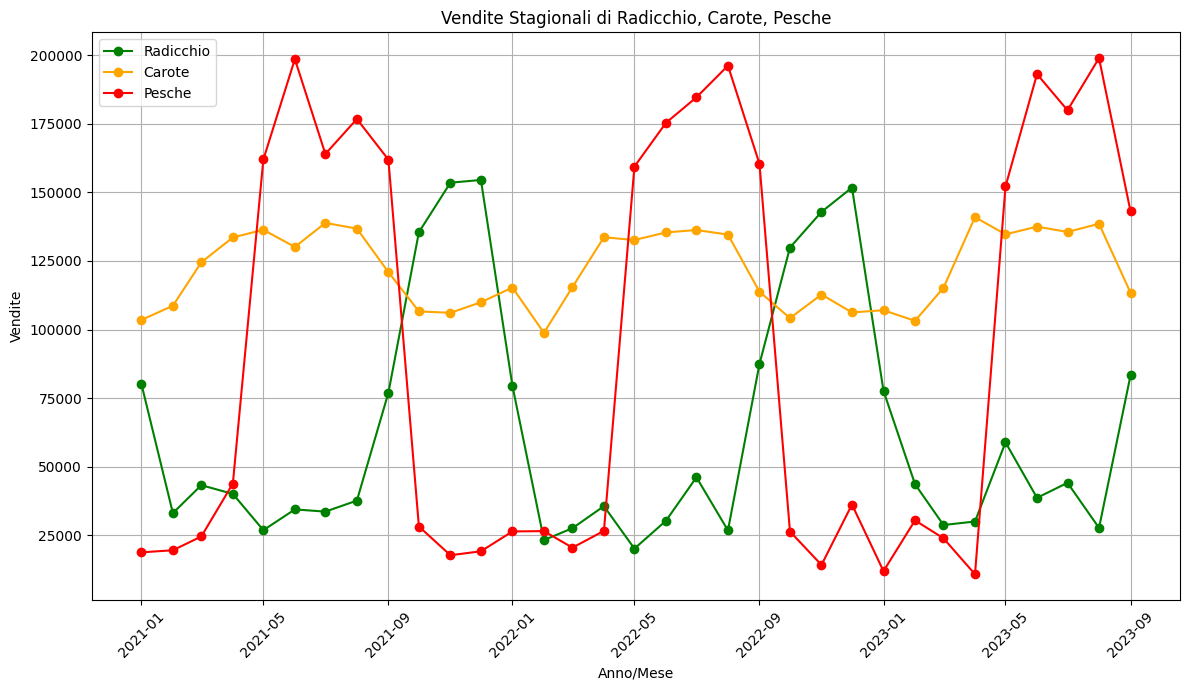

In [ ]:
seed = 123
np.random.seed(seed)
merged_df2 = merged_df.copy()

# Parametri generali
min_unif_best = 2.1
max_unif_best = 2.8
min_unif_border = 1.5
max_unif_border = 2.0
min_unif_offseason = 0.5
max_unif_offseason = 1.0
noise_factor_best = 0.05
noise_factor_border = 0.1
noise_factor_offseason = 0.15

# RADICCHIO

trend_factors_radicchio = {
    'prec': 1,
    'rad': 0.8,
    'temp_mean': 1.2,
    'PPA_ortive': 0.5,
    'PPA_concimi': 0.3,
    'PPA_insetticidi': 0.2
    }

event_factors_radicchio = {10: 1.15}  # Ottobre - Festa del Radicchio in Veneto (aumento del 15% nelle vendite di radicchio)
best_months_radicchio = [10, 11, 12]  # Mesi di picco stagionale (es. ottobre - dicembre)
border_months_radicchio = [9, 1]  # Mesi di transizione (inizio/fine stagione)
peak_value_radicchio = 480000  # Esempio di valore di picco per Radicchio

merged_df2['Radicchio'] = create_ortaggio(merged_df = merged_df2,
                                          seasonal_factor=80,
                                          trend_factors=trend_factors_radicchio,
                                          base_sales=28000,
                                          event_factors=event_factors_radicchio,
                                          noise_factor=0.03
                                          )

merged_df2['Radicchio'] = merged_df2.apply(lambda row: fix_qty_ortaggio(row=row,
                                                                        best_months=best_months_radicchio,
                                                                        border_months=border_months_radicchio,
                                                                        ortaggio="Radicchio",
                                                                        peak_value=48000,
                                                                        max_all=np.max(merged_df2['Radicchio'])
                                                                        ),
                                           axis=1)

## CAROTE

# Parametri specifici per le carote
trend_factors_carote = {
    'prec': 0.8,  # Precipitazione
    'rad': 1.0,  # Radiazione solare (le carote non sono così sensibili quanto altre piante)
    'temp_mean': 1.0,  # Temperatura media (più moderate rispetto ad altri ortaggi)
    'PPA_ortive': 0.5,  # PPA ortive
    'PPA_concimi': 0.3,  # PPA concimi
    'PPA_insetticidi': 0.2  # PPA insetticidi
}

event_factors_carote = {10: 1.1}  # Ottobre - Eventi che aumentano il 10% delle vendite di carote

# Mesi di picco per le carote (ad esempio, la stagione di picco potrebbe essere autunnale)
# Parametri personalizzati per Carote
best_months_carote = [4, 5, 6, 7, 8]  # Mesi di picco stagionale (aprile - agosto)
border_months_carote = [3, 9]  # Mesi di transizione (marzo, settembre)
peak_value_carote = 80000  # Ridotto il valore di picco per Carote (100.000 kg)

# Parametri di distribuzione ancora più piatta per Carote
min_unif_best_carote = 1.2  # Minimo per i mesi di picco stagionale
max_unif_best_carote = 1.3  # Massimo per i mesi di picco stagionale
min_unif_border_carote = 1.0  # Minimo per i mesi di transizione
max_unif_border_carote = 1.1  # Massimo per i mesi di transizione
min_unif_offseason_carote = 0.9  # Minimo per i mesi fuori stagione
max_unif_offseason_carote = 0.9  # Massimo per i mesi fuori stagione

# Parametri di rumore personalizzati per Carote
noise_factor_best_carote = 0.02  # Rumore ridotto per la stagione
noise_factor_border_carote = 0.05  # Rumore ridotto per la transizione
noise_factor_offseason_carote = 0.08  # Rumore moderato per fuori stagione



# Applicazione della funzione di creazione per le carote
merged_df2['Carote'] = create_ortaggio(merged_df = merged_df2,
                                        seasonal_factor=80,  # Il fattore stagionale per le carote
                                        trend_factors=trend_factors_carote,
                                        base_sales=400000,
                                        event_factors=event_factors_carote,
                                        noise_factor=0.05  # Rumore moderato
                                        )

# Funzione applicata per Carote
merged_df2['Carote'] = merged_df2.apply(lambda row: fix_qty_ortaggio(row=row,
                                                                     best_months=best_months_carote,
                                                                     border_months=border_months_carote,
                                                                     ortaggio="Carote",
                                                                     peak_value=peak_value_carote,
                                                                     max_all=np.max(merged_df2['Carote']),
                                                                     min_unif_best=min_unif_best_carote,
                                                                     max_unif_best=max_unif_best_carote,
                                                                     min_unif_border=min_unif_border_carote,
                                                                     max_unif_border=max_unif_border_carote,
                                                                     min_unif_offseason=min_unif_offseason_carote,
                                                                     max_unif_offseason=max_unif_offseason_carote,
                                                                     noise_factor_best=noise_factor_best_carote,
                                                                     noise_factor_border=noise_factor_border_carote,
                                                                     noise_factor_offseason=noise_factor_offseason_carote
                                                                     ), axis=1)

## PESCHE

# Parametri specifici per le pesche
trend_factors_pesche = {
    'prec': 1,  # Precipitazioni
    'rad': 0.8,  # Radiazione solare
    'temp_mean': 1.5,  # Temperatura media (pesche molto sensibili alla temperatura)
    'PPA_ortive': 0.5,  # Fertilizzazione
    'PPA_concimi': 0.3,  # Concimi
    'PPA_insetticidi': 0.2  # Insetticidi
}

# Fattori per eventi (se c'è un evento stagionale importante, ad esempio, la raccolta)
event_factors_pesche = {6: 1.2, 7: 1.3, 8: 1.15}  # Aumento nelle vendite in estate (giugno, luglio, agosto)
best_months_pesche = [6, 7, 8]  # Giugno, Luglio, Agosto
border_months_pesche = [5, 9]  # Maggio e Settembre (transizione)
peak_value_pesche = 50000

# Parametri aggiornati per la distribuzione delle Pesche
min_unif_best_pesche = 3.0  # Minimo per i mesi di picco stagionale
max_unif_best_pesche = 3.4  # Massimo per i mesi di picco stagionale
min_unif_border_pesche = 1.2  # Minimo per i mesi di transizione
max_unif_border_pesche = 1.4  # Massimo per i mesi di transizione
min_unif_offseason_pesche = 0.1  # Minimo per i mesi fuori stagione
max_unif_offseason_pesche = 0.3  # Massimo per i mesi fuori stagione

# Parametri di rumore aggiornati per Pesche
noise_factor_best_pesche = 0.01  # Rumore molto ridotto per la stagione
noise_factor_border_pesche = 0.05  # Rumore moderato per la transizione
noise_factor_offseason_pesche = 0.2  # Rumore elevato per fuori stagione

# Funzione per calcolare le vendite delle pesche
merged_df2['Pesche'] = create_ortaggio(merged_df=merged_df2,
                                        seasonal_factor=100,
                                        trend_factors=trend_factors_pesche,
                                        base_sales=50000,
                                        event_factors=event_factors_pesche,
                                        noise_factor=0.03)

# Applicazione della funzione per simulare la stagionalità con nuove configurazioni
merged_df2['Pesche'] = merged_df2.apply(lambda row: fix_qty_ortaggio(row=row,
                                                                    best_months=[6, 7, 8],
                                                                    border_months=[5, 9],
                                                                    ortaggio="Pesche",
                                                                    peak_value=120000,
                                                                    max_all=np.max(merged_df2['Pesche']),
                                                                    min_unif_best=min_unif_best_pesche,
                                                                    max_unif_best=max_unif_best_pesche,
                                                                    min_unif_border=min_unif_border_pesche,
                                                                    max_unif_border=max_unif_border_pesche,
                                                                    min_unif_offseason=min_unif_offseason_pesche,
                                                                    max_unif_offseason=max_unif_offseason_pesche,
                                                                    noise_factor_best=noise_factor_best_pesche,
                                                                    noise_factor_border=noise_factor_border_pesche,
                                                                    noise_factor_offseason=noise_factor_offseason_pesche
                                                                    ), axis=1)


## PLOT RISULTATI
merged_df2.loc[merged_df2["Pesche"] > 200000, "Pesche"] = merged_df2["Pesche"] - 200000
merged_df2["Carote"] = merged_df2["Carote"] + 35000
#plot_ts_ort(merged_df2, 'Radicchio')
#plot_ts_ort(merged_df2, 'Carote')
#plot_ts_ort(merged_df2, 'Pesche')
plot_all_ts(merged_df2, ['Radicchio', 'Carote', 'Pesche'])
#car 2.500.000, pes 19.143.000, rad 8.333.333 --> produzione mensile in veneto chiesta a chatgpt

## Modelling Phase

In [ ]:
merged_df2.drop(columns=["Mese"], inplace=True)
merged_df2.head()

,Anno_Mese,prec,rad,temp_min,temp_mean,temp_max,PPA_ortive,PPA_concimi,PPA_insetticidi,Carote,Radicchio,Pesche
0,2021-01-01,2.825806,4.386645,-0.754839,3.000000,7.341935,111.7,93.4,115.2,103482,80235,18758
1,2021-02-01,1.100000,7.989321,3.000000,7.046429,11.914286,112.2,96.8,114.9,108650,33067,19523
2,2021-03-01,0.212903,15.490258,1.880645,8.070968,14.722581,111.4,98.6,114.4,124506,43244,24547
3,2021-04-01,3.806667,17.881933,6.170000,11.463333,16.483333,111.3,100.5,114.5,133556,40067,43853
4,2021-05-01,4.580645,21.416387,10.951613,15.774194,21.006452,110.6,101.2,114.7,136352,26833,161983


In [ ]:
def fit_models(merged_df, ort):
  pesche_series = merged_df[ort]

  sarima_model = SARIMAX(pesche_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
  sarima_fit = sarima_model.fit(disp=False)

  # Predizioni SARIMA
  # sarima_pred = sarima_fit.predict(start=0, end=len(pesche_series)-1)
  sarima_pred = sarima_fit.predict(start=0, end=len(pesche_series)-1, dynamic=False)

  # Regressione lineare
  merged_df1 = merged_df.copy()
  merged_df1[['temp_mean', 'PPA_insetticidi']] = merged_df1[['temp_mean', 'PPA_insetticidi']].apply(pd.to_numeric, errors='coerce')
  merged_df1['Anno_Mese'] = pd.to_datetime(merged_df1['Anno_Mese'], errors='coerce')
  merged_df1['Mese'] = merged_df1['Anno_Mese'].dt.month
  dummies = pd.get_dummies(merged_df1['Mese'], prefix='Mese', drop_first=True)
  X1 = pd.concat([merged_df1[['temp_mean', 'PPA_insetticidi']], dummies], axis=1)
  X1 = sm.add_constant(X1)
  X1 = X1.replace({False: 0, True: 1})
  y = merged_df1[ort]

  linear_model = LinearRegression()
  linear_model.fit(X1, y)

  linear_pred = linear_model.predict(X1)

  # Calcolo R2 e MSE
  sarima_r2 = r2_score(pesche_series, sarima_pred)
  sarima_mse = mean_squared_error(pesche_series, sarima_pred)
  linear_r2 = r2_score(y, linear_pred)
  linear_mse = mean_squared_error(y, linear_pred)

  print("SARIMA R2:", sarima_r2)
  print("SARIMA MSE:", sarima_mse)
  print("Linear Regression R2:", linear_r2)
  print("Linear Regression MSE:", linear_mse)

  # Plot delle predizioni
  plt.figure(figsize=(12, 6))
  plt.plot(merged_df["Anno_Mese"], pesche_series, label=ort, marker='o', color='purple')
  plt.plot(merged_df["Anno_Mese"], sarima_pred, label="SARIMA Prediction", linestyle="--", color='blue')
  plt.plot(merged_df["Anno_Mese"], linear_pred, label="Linear Regression Prediction", linestyle="--", color='orange')
  plt.title(f"Modelli SARIMA e Linear Regression sulle Vendite di {ort}")
  plt.xlabel("Anno/Mese")
  plt.ylabel(f"Vendite di {ort}")
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-369-dd62708a715c>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X1 = X1.replace({False: 0, True: 1})


SARIMA R2: 0.0736844860305037
SARIMA MSE: 5334257020.5205765
Linear Regression R2: 0.9898366708101641
Linear Regression MSE: 58526289.65526425


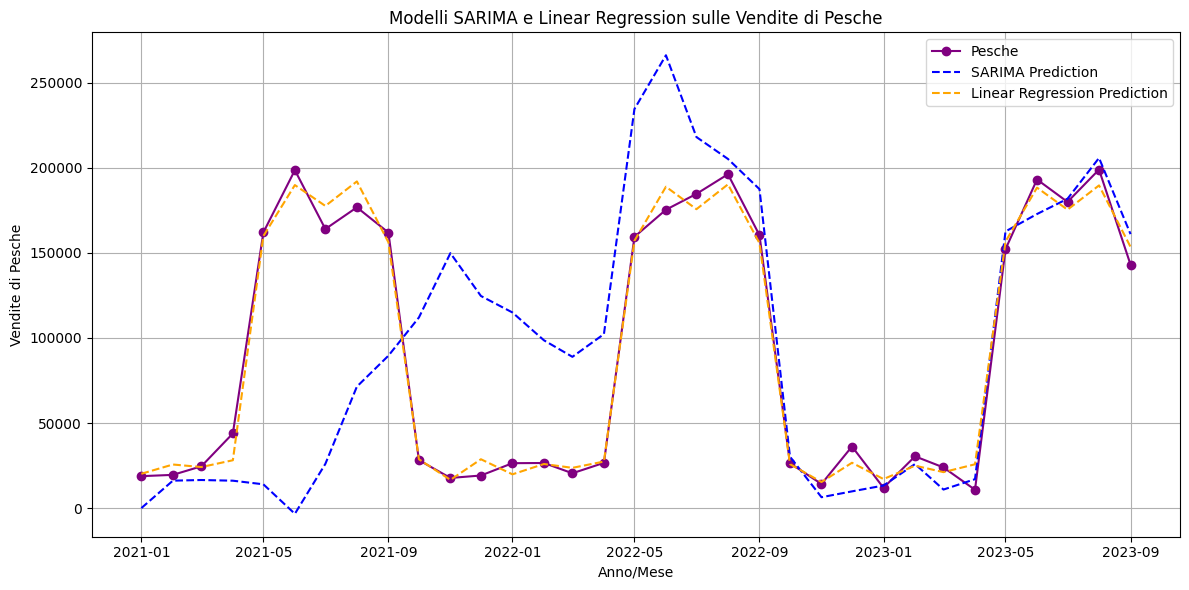

In [ ]:
fit_models(merged_df2, "Pesche")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-369-dd62708a715c>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X1 = X1.replace({False: 0, True: 1})


SARIMA R2: 0.005953848728649236
SARIMA MSE: 1835392182.6296558
Linear Regression R2: 0.9767983245025258
Linear Regression MSE: 42839232.13978602


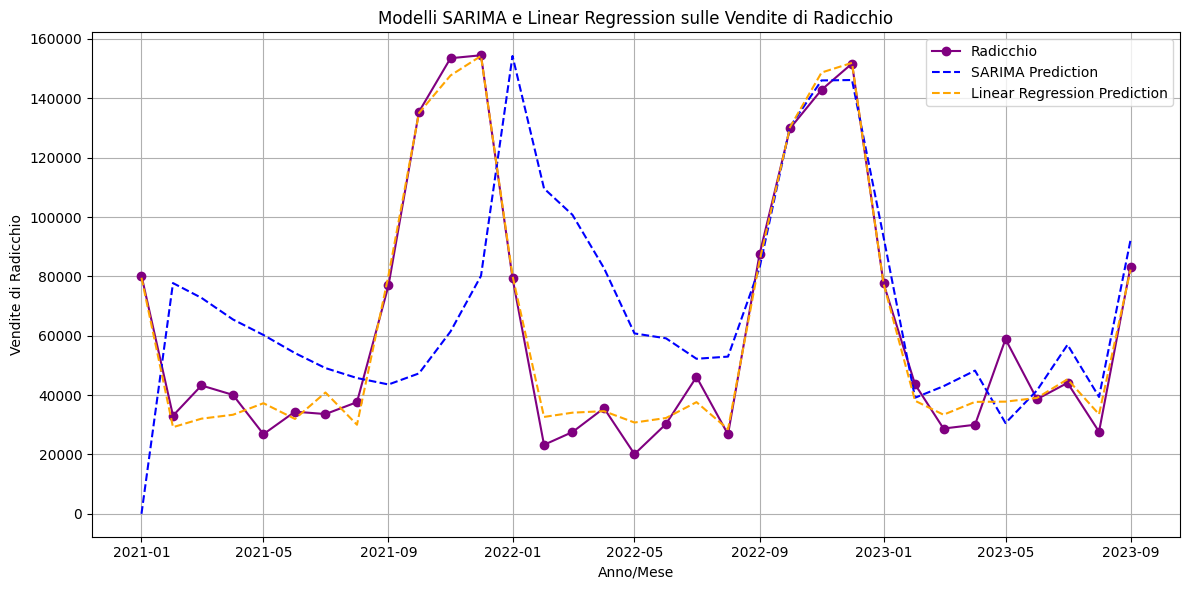

In [ ]:
fit_models(merged_df2, "Radicchio")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-369-dd62708a715c>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X1 = X1.replace({False: 0, True: 1})


SARIMA R2: -2.751517087783209
SARIMA MSE: 696687138.565845
Linear Regression R2: 0.9479805990072236
Linear Regression MSE: 9660424.510816168


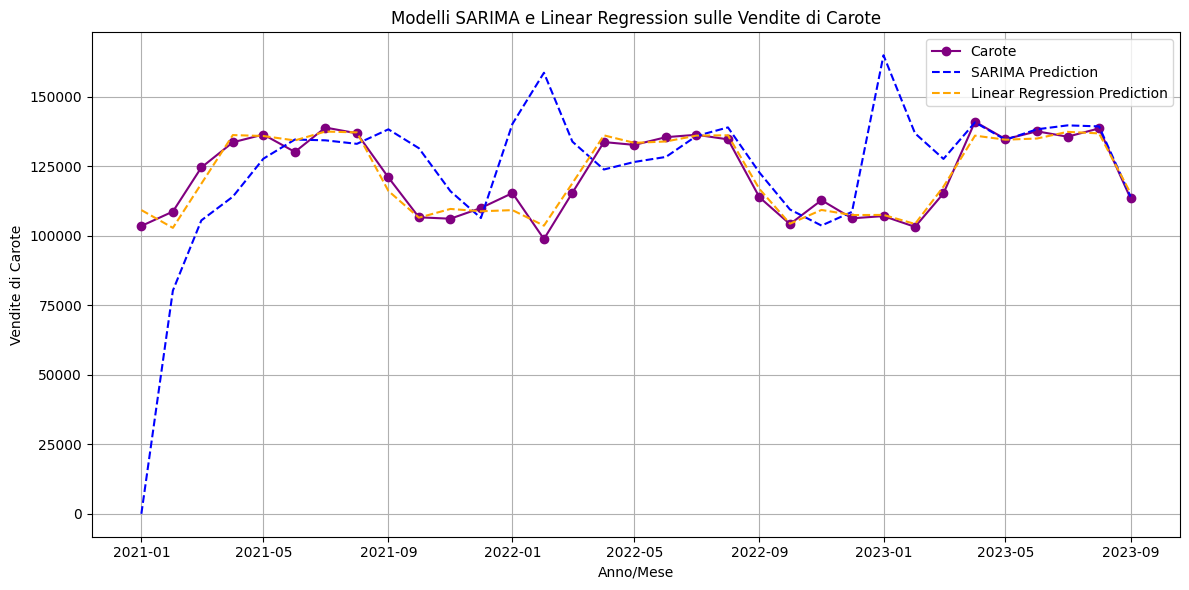

In [ ]:
fit_models(merged_df2, "Carote")

In [ ]:
# Save the generated data to a CSV file
output_file_path = "/mnt/data/generated_sales_data.csv"
merged_df2.to_csv(output_file_path, index=False)

print(f"The data has been saved as 'generated_sales_data.csv'. You can download it from: {output_file_path}")